In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import time

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

228813984/228813984 [==============================] - 73s 0us/step
3670


In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0])).show()

In [6]:
PIL.Image.open(str(roses[1])).show()

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0])).show()

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0])).show()

In [7]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [10]:
num_classes = len(class_names)
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0050650807 0.9977307


In [14]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 46s 491ms/step - loss: 1.3172 - accuracy: 0.4309 - val_loss: 1.0952 - val_accuracy: 0.5450
Epoch 2/10
92/92 [==============================] - 44s 476ms/step - loss: 0.9985 - accuracy: 0.6008 - val_loss: 0.9891 - val_accuracy: 0.5872
Epoch 3/10
92/92 [==============================] - 45s 486ms/step - loss: 0.8172 - accuracy: 0.6928 - val_loss: 1.0307 - val_accuracy: 0.5777
Epoch 4/10
92/92 [==============================] - 44s 475ms/step - loss: 0.6442 - accuracy: 0.7558 - val_loss: 0.9553 - val_accuracy: 0.6403
Epoch 5/10
92/92 [==============================] - 41s 447ms/step - loss: 0.4339 - accuracy: 0.8430 - val_loss: 1.1226 - val_accuracy: 0.6322
Epoch 6/10
92/92 [==============================] - 41s 444ms/step - loss: 0.2817 - accuracy: 0.8988 - val_loss: 1.0953 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 41s 449ms/step - loss: 0.1518 - accuracy: 0.9520 - val_loss: 1.2199 - val_accuracy: 0.6649

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

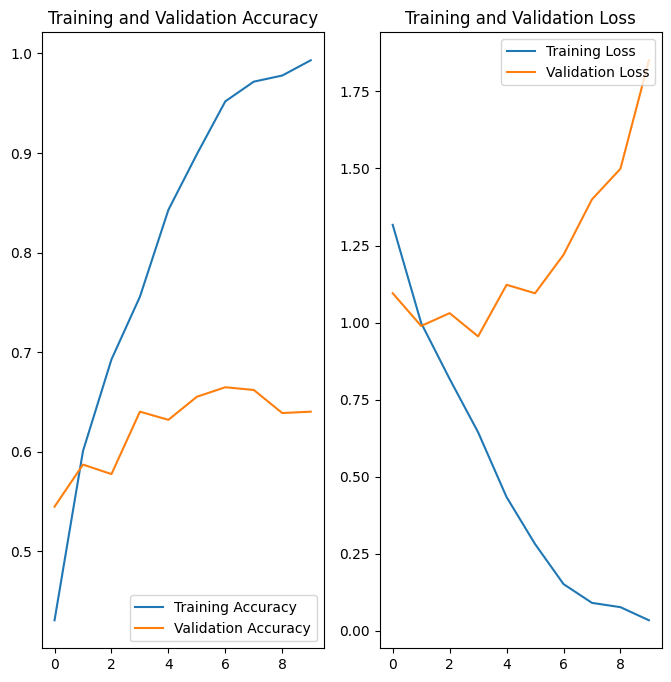

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

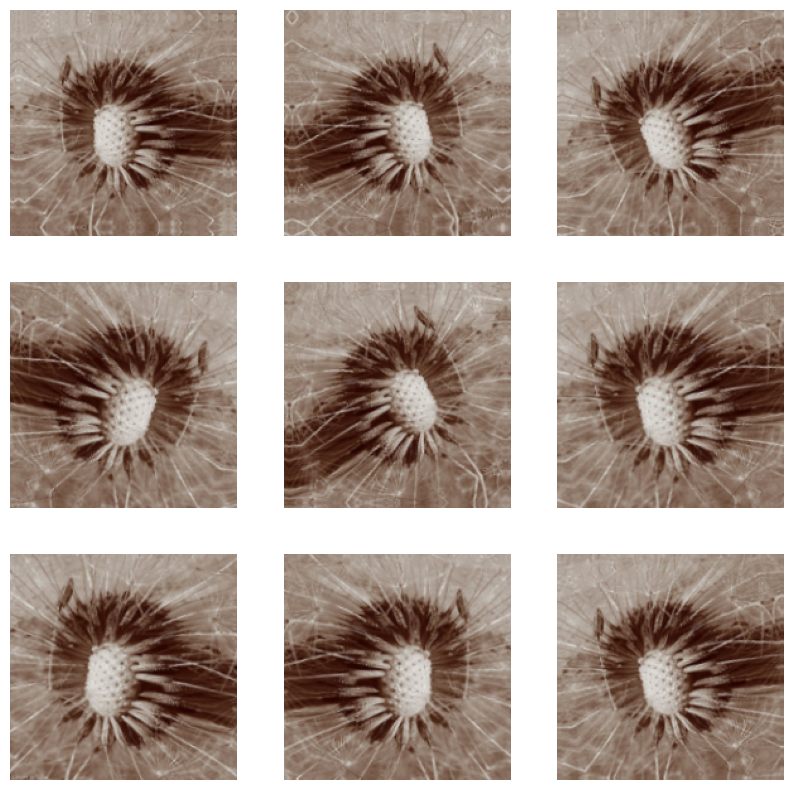

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
start_time = time.time()
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
end_time = time.time()
print(f'経過:{end_time-start_time}')

Epoch 1/10


92/92 [==============================] - 53s 576ms/step - loss: 1.2470 - accuracy: 0.4779 - val_loss: 1.1092 - val_accuracy: 0.5477
Epoch 2/10
92/92 [==============================] - 76s 829ms/step - loss: 1.0433 - accuracy: 0.5766 - val_loss: 1.0692 - val_accuracy: 0.5668
Epoch 3/10
92/92 [==============================] - 65s 708ms/step - loss: 0.9494 - accuracy: 0.6281 - val_loss: 1.0356 - val_accuracy: 0.5722
Epoch 4/10
92/92 [==============================] - 50s 539ms/step - loss: 0.8778 - accuracy: 0.6570 - val_loss: 0.9008 - val_accuracy: 0.6471
Epoch 5/10
92/92 [==============================] - 49s 536ms/step - loss: 0.7996 - accuracy: 0.6897 - val_loss: 0.8295 - val_accuracy: 0.6717
Epoch 6/10
92/92 [==============================] - 50s 543ms/step - loss: 0.7512 - accuracy: 0.7081 - val_loss: 0.8740 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 48s 526ms/step - loss: 0.7132 - accuracy: 0.7255 - val_loss: 0.9492 - val_accuracy: 0.6649
Epoch 8/10

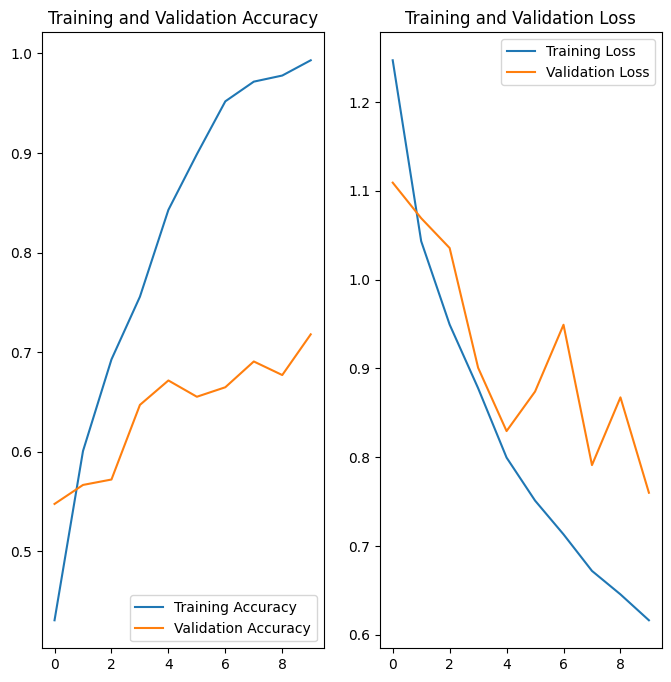

In [26]:
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()